# IMPORTS
## DATA SCIENCE PACKAGES

In [25]:
# Import des librairies
import ast
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter
import pickle
import time
import string
import logging
logging.disable(logging.WARNING)

In [26]:
import re
# as per recommendation from @freylis, compile once only
CLEANR = re.compile('<(?s:.)*?>') 
from collections import Counter

## TEXT PROCESSING PACKAGES

In [27]:
import nltk
from nltk.stem import WordNetLemmatizer

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 'run', 'install', 'use', 'using', 'find'])
#from nltk.corpus import stopwords
stop_w = list(set(stop_words)) + ['[', ']', ',', '.', ':', '?', '(', ')', '\\\\b']

## SCI-KIT LEARN packages

In [84]:
#from sklearn import cluster, metrics, preprocessing, manifold, decomposition, model_selection, base, svm

from sklearn import svm

from sklearn.dummy import DummyClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import SGDClassifier, LogisticRegression

from sklearn.metrics import auc, roc_curve, SCORERS, accuracy_score, classification_report, precision_recall_curve
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, f1_score

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_val_score, ShuffleSplit

from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier

from sklearn.naive_bayes import MultinomialNB

from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, LabelBinarizer

from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.svm import SVC #Linear SVC would have been the simpler linear version

from sklearn.tree import DecisionTreeClassifier


In [29]:
path = '/Users/souha_kassab/OC_P5/static/csv/'

## HELPERS

In [30]:
# METHOD TO COMPUTE MEMORY USAGE DURING AN OPERATION
BYTES_TO_MB_DIV = 0.000001
def print_memory_usage_of_data_frame(df):
    mem = round(df.memory_usage().sum() * BYTES_TO_MB_DIV, 3) 
    print("Memory usage is " + str(mem) + " MB")
# ------------------------------------------------------------ #
# METHOD TO CREATE A DENSE DATAFRAME FROM SPARSE TF-IDF MATRIX
def densify(tfidf_vector, features):
    docterm = pd.DataFrame(tfidf_vector.todense(), columns=features)
    print(docterm.info() )
    return docterm
# ------------------------------------------------------------ #


## Prepare Data

### Import corpus

In [31]:
shuffled_data = pd.read_csv(path + 'REDUCED_Multiclass_data_80pcent_tags.csv', index_col=[0], 
                            low_memory=False)
#shuffled_data = shuffled_data.sample(frac=1)

In [32]:
print_memory_usage_of_data_frame(shuffled_data)

Memory usage is 0.272 MB


In [33]:
shuffled_data['Tags_words'] = shuffled_data['Tags_words'].apply(lambda x: ast.literal_eval(x))

In [34]:
shuffled_data.head()

,AnswerCount,Tags_words,unique_commn_tag,unique_rare_tag,Title_bow,Body_bow,Body_bow_lem,Title_bow_lem,unique_tag,concatenated_query_bow_lem
0,5,"[javascript, jquery, html, forms, contentedita...",javascript,contenteditable,get content span,get contents span looking way vanilla jqueryja...,get content span looking way vanilla jqueryjav...,get content span,javascript,get content span get content span looking way ...
18,2,"[javascript, performance, module, webpack, bab...",javascript,babeljs,modules import destructuring performances,recently read material docs notice example use...,recently read material doc notice example used...,module import destructuring performance,javascript,module import destructuring performance recent...
35,7,"[python, windows, process, subprocess, fork]",python,subprocess,what best way duplicate fork windows,how implement logic allow reproduce windows fu...,implement logic allow reproduce window functio...,best way duplicate fork window,python,best way duplicate fork window implement logic...
61,2,"[python, user-interface, drag-and-drop, wxpyth...",python,wxwidgets,wxpython how examine dragged data ondragover,bit perplexed drag drop wxpython perhaps quest...,bit perplexed drag drop wxpython perhaps quest...,wxpython examine dragged data ondragover,python,wxpython examine dragged data ondragover bit p...
83,6,"[c++, debugging, gdb, breakpoints, memory-access]",c++,memory-access,can set breakpoint 'memory access gdb,running application gdb want set breakpoint ti...,running application gdb want set breakpoint ti...,set breakpoint 'memory access gdb,c++,set breakpoint 'memory access gdb running appl...


### Inspect data

<Axes: ylabel='count'>

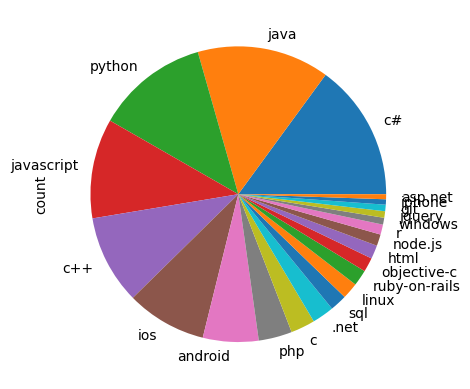

In [35]:
shuffled_data['unique_tag'].value_counts().plot(kind='pie')

### Split data

In [36]:
X = shuffled_data['concatenated_query_bow_lem']
y = shuffled_data['unique_tag']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42, stratify=y)
print(X_train.shape, X_test.shape)

(2163,) (927,)


### Check that both sets include all tags

In [37]:
print(sorted(y_train.unique()))

['.net', 'android', 'asp.net', 'c', 'c#', 'c++', 'git', 'html', 'ios', 'iphone', 'java', 'javascript', 'jquery', 'linux', 'node.js', 'objective-c', 'php', 'python', 'r', 'ruby-on-rails', 'sql', 'windows']


In [38]:
print(sorted(y_test.unique()))

['.net', 'android', 'asp.net', 'c', 'c#', 'c++', 'git', 'html', 'ios', 'iphone', 'java', 'javascript', 'jquery', 'linux', 'node.js', 'objective-c', 'php', 'python', 'r', 'ruby-on-rails', 'sql', 'windows']


In [39]:
print(y_train.head(), 
      '\n', y_test.head())

30503             java
12810          node.js
6361     ruby-on-rails
48143           python
32331              c++
Name: unique_tag, dtype: object 
 5648           java
9950        android
36901            c#
43918    javascript
23999        python
Name: unique_tag, dtype: object


In [40]:
print(X_train.head(), 
      '\n', X_test.head())

30503    using generic spring data jpa repository numbe...
12810    implement sso authentication active directory ...
6361     rail fixture loading rspec trying learn rspec ...
48143    decorator vs. class python web development 've...
32331    function using std mutex make null check addre...
Name: concatenated_query_bow_lem, dtype: object 
 5648     set page orientation word document use apache ...
9950     handle webview confirm dialog displaying webpa...
36901    populating dataset csv file would like read co...
43918    puppeteer get content element nodelist trying ...
23999    get stdout stderr forked process subprocess pr...
Name: concatenated_query_bow_lem, dtype: object


### Features engineering

In [41]:
# BAG OF WORDS INSTANCE
bow_vect = CountVectorizer(stop_words=stop_w, max_df=0.95, min_df=1)
# TF-IDF INSTANCE
tf_vect = TfidfVectorizer(stop_words=stop_w, max_df=0.95, min_df=1)

bow_fit = bow_vect.fit(X_train)
tf_fit = tf_vect.fit(X_train)
#bow_fit.get_feature_names_out()
#print(tf_fit.get_feature_names_out())
tf_fit.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 0.95,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': ['after',
  'below',
  'weren',
  'out',
  'shan',
  'these',
  'by',
  'but',
  'whom',
  'run',
  'who',
  'on',
  't',
  'doesn',
  'our',
  'my',
  'what',
  'aren',
  'before',
  'it',
  'a',
  'you',
  'herself',
  'has',
  "didn't",
  'were',
  'itself',
  'from',
  'only',
  'should',
  'own',
  'and',
  'being',
  'if',
  'because',
  'did',
  'this',
  "hadn't",
  'too',
  'am',
  'y',
  'o',
  "wouldn't",
  "she's",
  'are',
  'each',
  'further',
  'or',
  'having',
  'which',
  'into',
  'to',
  'they',
  'had',
  'his',
  'all',
  'didn',
  'won',
  "you'd",
  'ourselves',
  'have',
  "you're",
  'can',
  'between',
  'use',
  're',
  'shouldn',
  "hasn't",
  'needn',
  '

### Normalize data using TF-IDF

In [42]:
bow_transform = bow_fit.transform(X_train)  
tf_transform = tf_fit.transform(X_train) 
tf_transform
#tf_transform.todense()

<2163x35732 sparse matrix of type '<class 'numpy.float64'>'
	with 154716 stored elements in Compressed Sparse Row format>

In [43]:
# display the document-term matrix
vocab = tf_fit.get_feature_names_out()

X_train_dense = densify(tf_transform, vocab)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2163 entries, 0 to 2162
Columns: 35732 entries, 00 to 视频
dtypes: float64(35732)
memory usage: 589.7 MB
None


In [44]:
X_test_dense = densify(tfidf_vector=tf_fit.transform(X_test), features=vocab)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 927 entries, 0 to 926
Columns: 35732 entries, 00 to 视频
dtypes: float64(35732)
memory usage: 252.7 MB
None


In [45]:
stop

NameError: name 'stop' is not defined

# Models comparison

In [23]:
## METHOD TO TRAIN SEVERAL CLASSIFICATION ALGORITHMS AND COMPARE PERFORMANCE TO DUMMY ## 
def train_eval_model(model, X_train, y_train, X_test, y_test): 
    pipe = (model["classif"])
    start_time = time.time()
    # Fit model
    pipe.fit(X_train, y_train)
    print(pipe.get_params())
    
    # Check model
    train_predictions = pipe.predict(X_train)
    train_time = time.time() - start_time
    train_acc = accuracy_score(y_train, train_predictions)
    # Evaluate model
    test_predictions = pipe.predict(X_test)
    test_acc = accuracy_score(y_test, test_predictions)
    print(time)
    print(f'model {pipe} accuracy score on train set: {train_acc}; on test set: {test_acc}')

In [24]:
# Models to train 
models = [{"name": "Dummy Regressor", "classif": DummyClassifier()},
    {"name": "Decision Tree", "classif": DecisionTreeClassifier()},
    {"name": "Logistic Regressor", "classif": LogisticRegression(solver='lbfgs',max_iter=1000)},
    {"name": "SVM-C", "classif": svm.SVC(C=1.0, kernel='rbf', gamma=0.01, probability=True)} ]
trained_models = []
for model in models:
    # Fit model
    model_details = train_eval_model(model, X_train_dense, y_train, X_test_dense, y_test) 
    trained_models.append(model_details)
trained_models

{'constant': None, 'random_state': None, 'strategy': 'prior'}
<module 'time' (built-in)>
model DummyClassifier() accuracy score on train set: 0.14932963476652797; on test set: 0.1499460625674218
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
<module 'time' (built-in)>
model DecisionTreeClassifier() accuracy score on train set: 1.0; on test set: 0.5221143473570659
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
<module 'time' (built-in)>
model LogisticRegression(max_iter=1000) accuracy score on train set: 0.7905686546463245; on test 

[None, None, None, None]

LR seems to be performing better than decision tree as per accuracy, however LR is more sensitive to outliers than SVM
SVM has poor results and is much slower but LR results indicate we might have underfitting due to low data size, which would explain SVM results as well.

## Cross-validation

In [44]:
def cross_eval_lr():
    crossval_estimator = LogisticRegression(max_iter=1000)
    crossval_params = {'C': np.logspace(-1, 1, 3),
              'penalty': ['l1', 'l2'],
              'solver': ['newton-cg', 'liblinear', 'lbfgs']

    }
    cv_grid = GridSearchCV(estimator=crossval_estimator,
                    param_grid= crossval_params,
                    cv=3,
                    n_jobs=-1,
                    return_train_score=True,
                    verbose =0
                       )
    cv_grid.fit(X_train_dense, y_train) 
    best_params= cv_grid.best_params_
    return cv_grid, best_params

In [45]:
def fancy_results(grid):
    res = pd.DataFrame(grid.cv_results_) 
    cols = [i for i in res.columns if "split" not in i]
    res = res[cols]
    res = res.sort_values("rank_test_score")
    
    return res

In [46]:
lr_grid, cv_bestparams = cross_eval_lr()


/Users/souha_kassab/opt/miniconda3/envs/oc_p5/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
18 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/souha_kassab/opt/miniconda3/envs/oc_p5/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/souha_kassab/opt/miniconda3/envs/oc_p5/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/souha_kassab/opt/miniconda3/envs/

In [51]:
print(cv_bestparams)
fancy_results(lr_grid)


{'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
13,4.443079,0.057182,0.604358,0.017246,10.0,l1,liblinear,"{'C': 10.0, 'penalty': 'l1', 'solver': 'liblin...",0.620897,0.011172,1,0.999307,1.110223e-16
16,3.276521,0.022116,0.615196,0.019708,10.0,l2,liblinear,"{'C': 10.0, 'penalty': 'l2', 'solver': 'liblin...",0.615349,0.004577,2,0.998844,3.269102e-04
17,75.102220,1.624343,0.303191,0.032904,10.0,l2,lbfgs,"{'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs'}",0.611650,0.005190,3,0.999538,3.269102e-04
15,104.477662,10.630580,0.323871,0.096473,10.0,l2,newton-cg,"{'C': 10.0, 'penalty': 'l2', 'solver': 'newton...",0.611650,0.005190,3,0.999538,3.269102e-04
9,77.832021,1.335303,0.716717,0.066840,1.0,l2,newton-cg,"{'C': 1.0, 'penalty': 'l2', 'solver': 'newton-...",0.573740,0.003977,5,0.781553,4.837829e-03
11,47.649292,2.055910,0.613729,0.011883,1.0,l2,lbfgs,"{'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}",0.573740,0.003977,5,0.781553,4.837829e-03
7,3.306257,0.042949,0.616340,0.015291,1.0,l1,liblinear,"{'C': 1.0, 'penalty': 'l1', 'solver': 'libline...",0.570966,0.012109,7,0.618354,3.770112e-03
10,2.979455,0.121045,0.624171,0.021743,1.0,l2,liblinear,"{'C': 1.0, 'penalty': 'l2', 'solver': 'libline...",0.570504,0.002357,8,0.773925,7.659751e-03
3,38.507140,1.270336,0.744011,0.031520,0.1,l2,newton-cg,"{'C': 0.1, 'penalty': 'l2', 'solver': 'newton-...",0.319464,0.012423,9,0.429265,7.360926e-03
5,19.806069,0.635493,0.644294,0.025613,0.1,l2,lbfgs,"{'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}",0.319001,0.013060,10,0.429265,7.360926e-03


## Fit chosen model

In [90]:
cross_validated_lr = LogisticRegression(**cv_bestparams)
cross_validated_lr.fit(X_train_dense, y_train)
#train_eval_model(cross_validated_lr, X_train_dense, y_train, X_test_dense, y_test)


LogisticRegression(C=10.0, penalty='l1', solver='liblinear')

## Check chosen model

In [91]:
#PREDICT
train_predictions = cross_validated_lr.predict(X_train_dense)

In [92]:
# CLASSIFICATION REPORT ON TRAIN SET
print("\nClassification report:")
print(classification_report(y_train, train_predictions))


Classification report:
               precision    recall  f1-score   support

         .net       1.00      1.00      1.00        52
      android       0.99      1.00      1.00       132
      asp.net       1.00      1.00      1.00        12
            c       1.00      1.00      1.00        57
           c#       1.00      1.00      1.00       323
          c++       1.00      1.00      1.00       211
          git       1.00      1.00      1.00        15
         html       1.00      1.00      1.00        32
          ios       1.00      1.00      1.00       190
       iphone       1.00      1.00      1.00        13
         java       1.00      1.00      1.00       313
   javascript       1.00      1.00      1.00       236
       jquery       1.00      1.00      1.00        15
        linux       1.00      1.00      1.00        38
      node.js       1.00      1.00      1.00        27
  objective-c       1.00      1.00      1.00        34
          php       1.00      1.00      

In [100]:
#TEST CELL

AttributeError: 'function' object has no attribute 'get'

In [93]:
print(len(classification_report(y_train, train_predictions)))

1432


# Metrics to evaluate chosen model

## Confusion matrix

In [94]:
#PREDICT
test_predictions = cross_validated_lr.predict(X_test_dense)

In [95]:
print(type(cross_validated_lr).__name__)    
print("----------------------------------")
print("Confusion matrix:") # GIVEN IN SORTED ORDER
print(multilabel_confusion_matrix(y_test, test_predictions))

LogisticRegression
----------------------------------
Confusion matrix:
[[[898   7]
  [ 21   1]]

 [[861  10]
  [ 19  37]]

 [[920   2]
  [  5   0]]

 [[889  13]
  [ 17   8]]

 [[704  84]
  [ 38 101]]

 [[805  32]
  [ 33  57]]

 [[919   1]
  [  1   6]]

 [[908   5]
  [ 12   2]]

 [[806  40]
  [ 22  59]]

 [[919   3]
  [  5   0]]

 [[762  31]
  [ 30 104]]

 [[775  51]
  [ 32  69]]

 [[918   2]
  [  7   0]]

 [[906   4]
  [ 14   3]]

 [[909   6]
  [  8   4]]

 [[909   4]
  [ 10   4]]

 [[886   7]
  [ 16  18]]

 [[799  14]
  [ 14 100]]

 [[914   3]
  [ 10   0]]

 [[906   5]
  [  2  14]]

 [[906   4]
  [  9   8]]

 [[918   2]
  [  5   2]]]


In [96]:
MCM = multilabel_confusion_matrix(y_test, test_predictions)
n_classes = len(y_test.unique())
y_labels  = list(sorted(y_test.unique()))
y_labels

['.net',
 'android',
 'asp.net',
 'c',
 'c#',
 'c++',
 'git',
 'html',
 'ios',
 'iphone',
 'java',
 'javascript',
 'jquery',
 'linux',
 'node.js',
 'objective-c',
 'php',
 'python',
 'r',
 'ruby-on-rails',
 'sql',
 'windows']

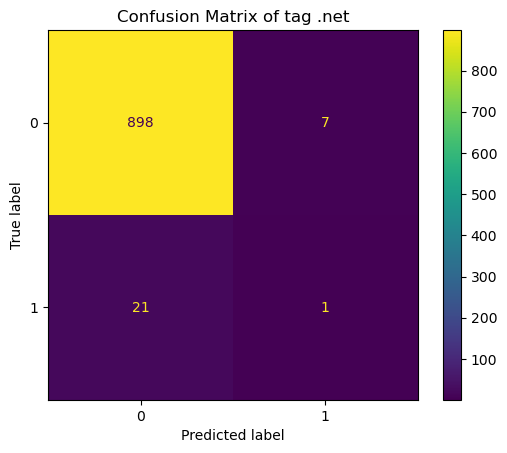

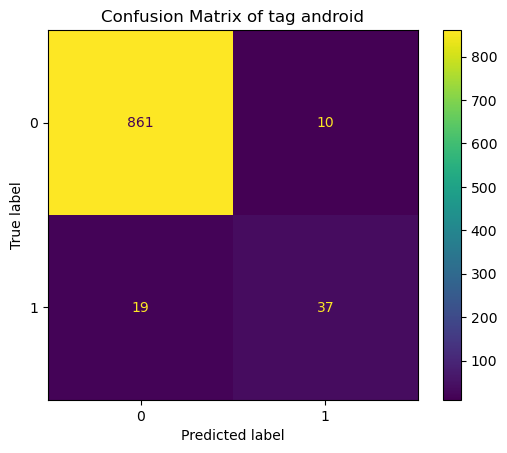

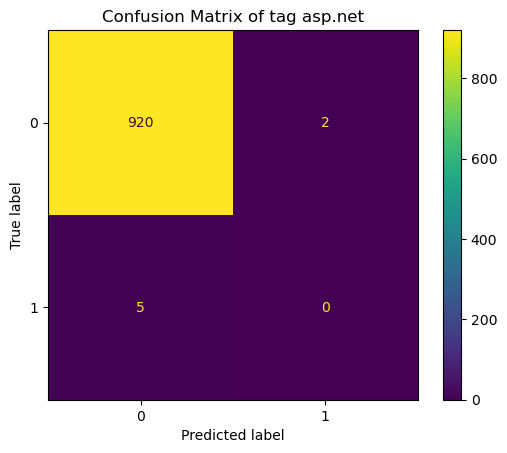

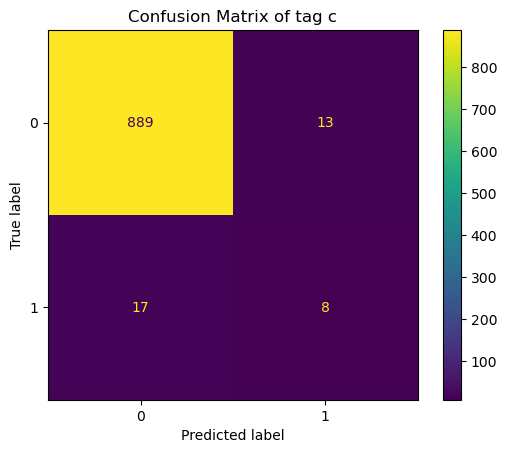

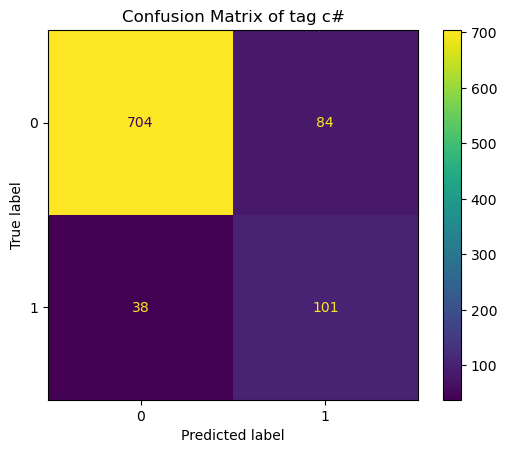

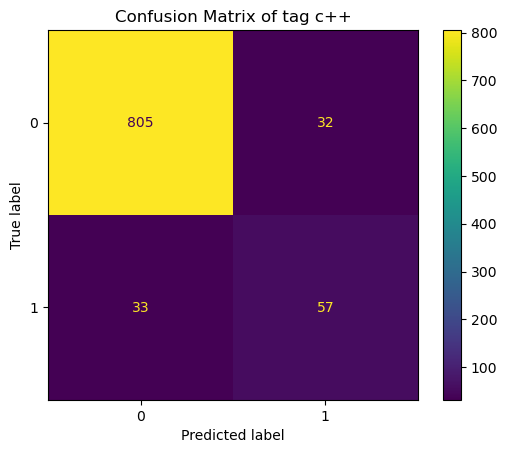

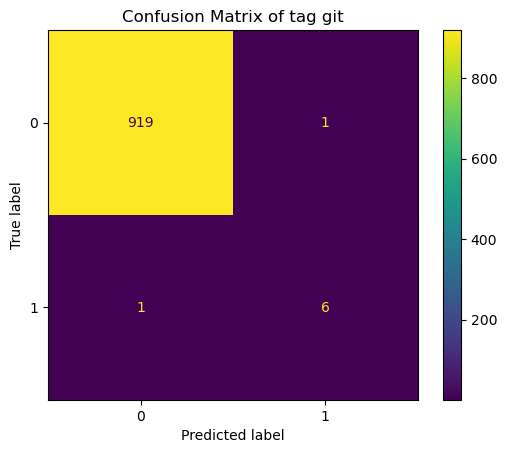

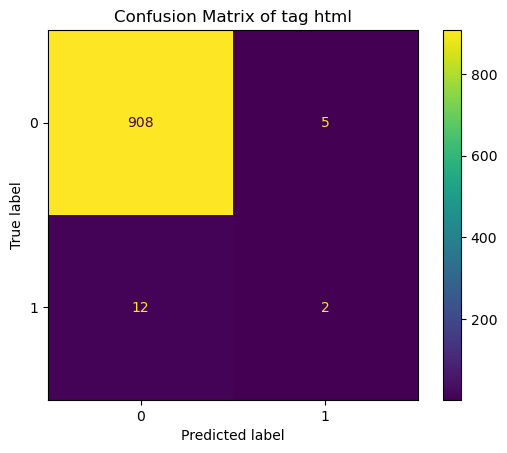

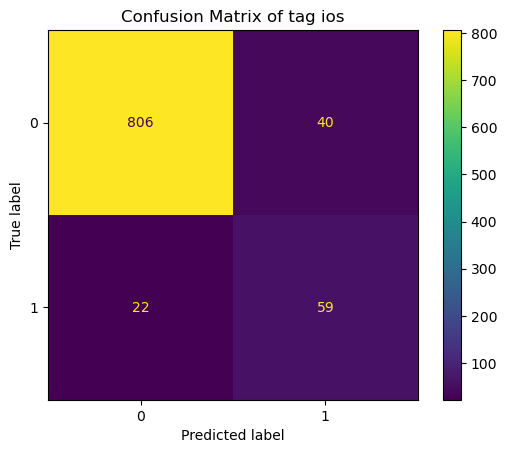

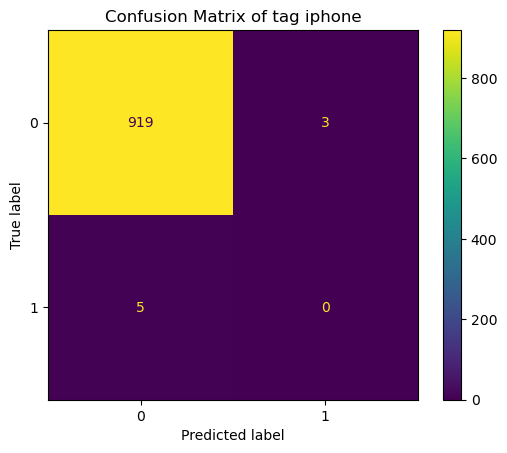

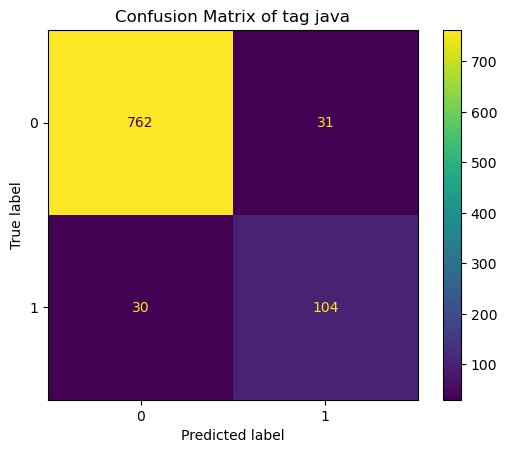

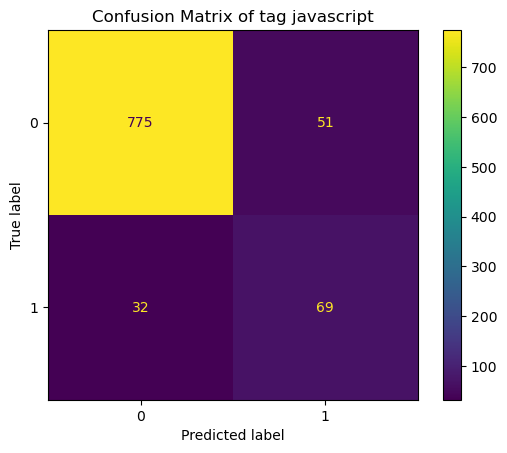

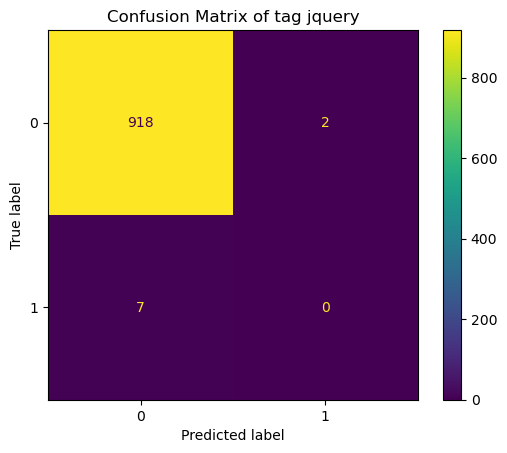

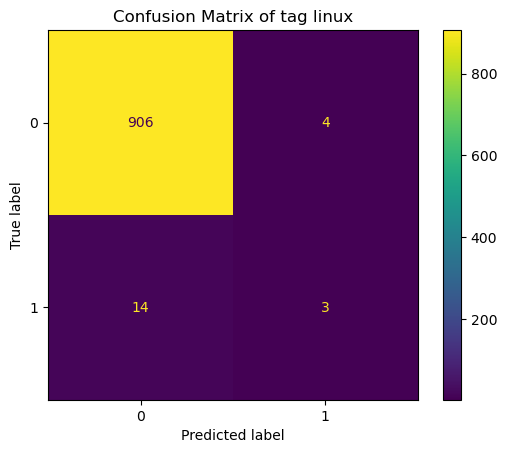

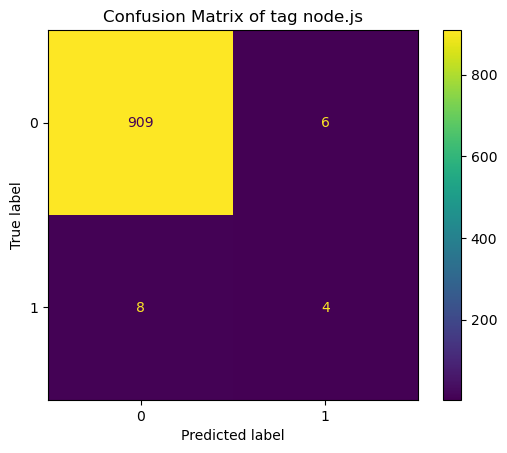

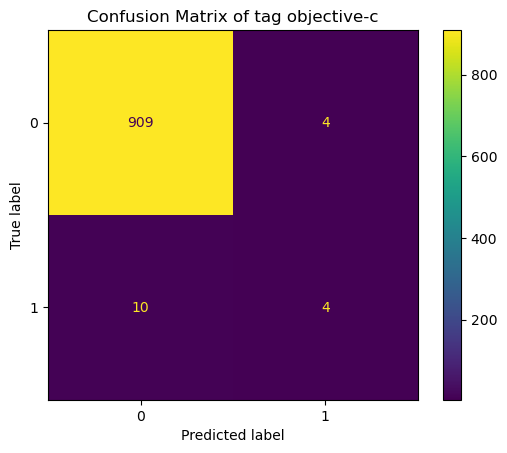

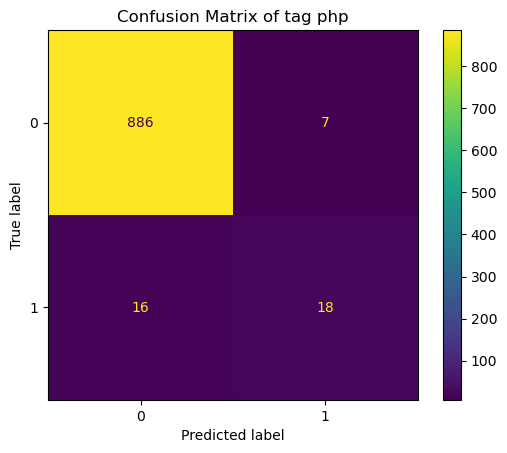

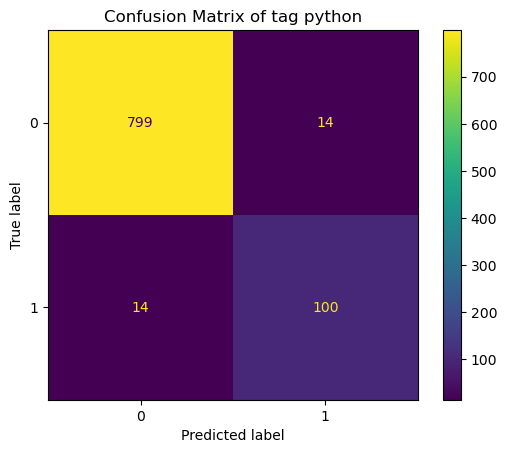

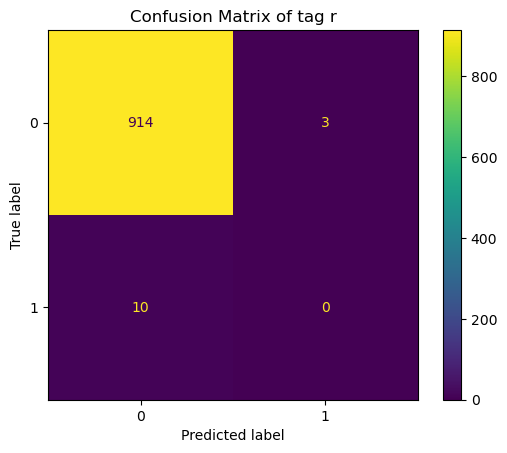

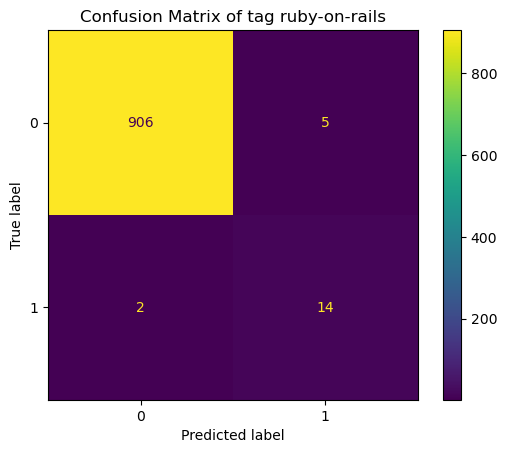

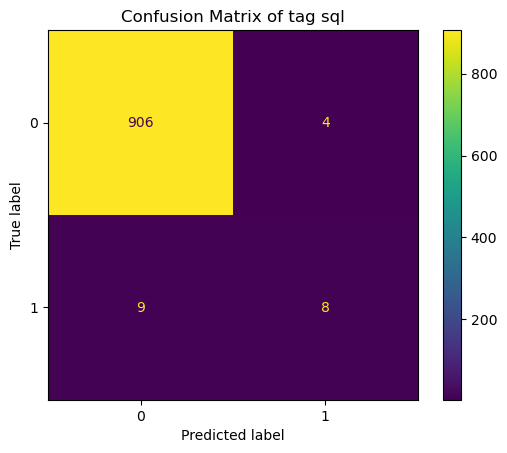

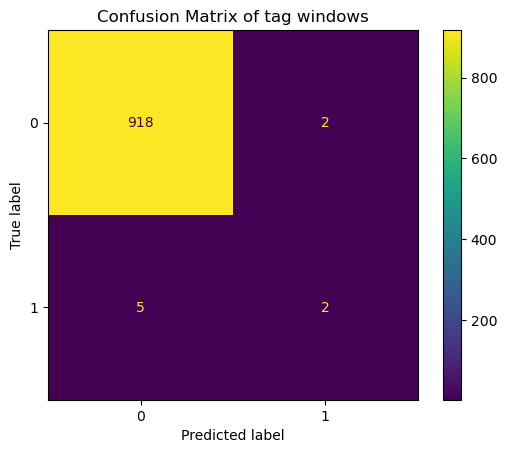

In [97]:
# Plotting matrices: code

for ntag in range(0, n_classes):
    cmd = ConfusionMatrixDisplay(MCM[ntag]).plot()
    plt.title(f'Confusion Matrix of tag {y_labels[ntag]}')
    plt.show()
    
    

In [ ]:
len(y_labels)

## Classification report

In [98]:
print("\nClassification report:")
print(classification_report(y_test, test_predictions))


Classification report:
               precision    recall  f1-score   support

         .net       0.12      0.05      0.07        22
      android       0.79      0.66      0.72        56
      asp.net       0.00      0.00      0.00         5
            c       0.38      0.32      0.35        25
           c#       0.55      0.73      0.62       139
          c++       0.64      0.63      0.64        90
          git       0.86      0.86      0.86         7
         html       0.29      0.14      0.19        14
          ios       0.60      0.73      0.66        81
       iphone       0.00      0.00      0.00         5
         java       0.77      0.78      0.77       134
   javascript       0.57      0.68      0.62       101
       jquery       0.00      0.00      0.00         7
        linux       0.43      0.18      0.25        17
      node.js       0.40      0.33      0.36        12
  objective-c       0.50      0.29      0.36        14
          php       0.72      0.53      

LR model seems unable to learn well enough if size of support of test set / training set for a given label is <=0.2! (iphone=5/13, jquery=7/15, asp.net=5/12, r=10/24)

## ROC, AUC
### Call for Labelbinarizer()
LabelBinarizer is a utility class to help create a label indicator matrix from a list of multiclass labels

In [101]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_train = label_binarizer.transform(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape

(927, 22)

In [109]:
# TEST CELL
print(list(label_binarizer.classes_))
y_onehot_test[:2]


['.net', 'android', 'asp.net', 'c', 'c#', 'c++', 'git', 'html', 'ios', 'iphone', 'java', 'javascript', 'jquery', 'linux', 'node.js', 'objective-c', 'php', 'python', 'r', 'ruby-on-rails', 'sql', 'windows']


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [239]:
# PREDICT PROBABILITIES
y_score = cross_validated_lr.predict_proba(X_test_dense)
print(y_score.shape, type(y_score))
y_score

(927, 22) <class 'numpy.ndarray'>


array([[2.86133209e-03, 1.74939106e-02, 6.69908146e-04, ...,
        1.55356493e-03, 1.48922669e-03, 5.92089205e-04],
       [4.10556094e-03, 1.57179969e-05, 3.79188184e-02, ...,
        2.67393217e-03, 2.56319583e-03, 1.01907963e-03],
       [7.60708702e-03, 2.70865158e-02, 2.76911955e-03, ...,
        3.98229649e-02, 1.17054070e-02, 2.45714846e-03],
       ...,
       [7.09842194e-03, 1.92165979e-02, 5.49840415e-04, ...,
        1.72370428e-03, 1.17335440e-03, 3.71912774e-04],
       [1.25909606e-02, 2.45072331e-02, 3.47413036e-03, ...,
        8.05675695e-03, 7.72310008e-03, 3.07056288e-03],
       [2.41770424e-02, 2.27551914e-02, 4.56418972e-03, ...,
        1.05846826e-02, 2.03384947e-02, 5.13895040e-02]])

In [103]:
df_yscore = pd.DataFrame(y_score, columns=label_binarizer.classes_)

### Averaged One-vs-Rest ROC AUC score

Micro-averaging aggregates the contributions from all the classes (using np.ravel) to compute the average metrics as shown in : https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

In [104]:
from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.95


In [105]:
from sklearn.metrics import roc_curve, auc

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["macro"], tpr["macro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.95


### Multiclass Receiver Operating Characteristic (ROC)

In [67]:
label_binarizer.classes_

array(['.net', 'android', 'asp.net', 'c', 'c#', 'c++', 'git', 'html',
       'ios', 'iphone', 'java', 'javascript', 'jquery', 'linux',
       'node.js', 'objective-c', 'php', 'python', 'r', 'ruby-on-rails',
       'sql', 'windows'], dtype='<U13')

In [125]:
np.nonzero(np.ravel(label_binarizer.classes_ == "asp.net"))[0]

array([2])

0


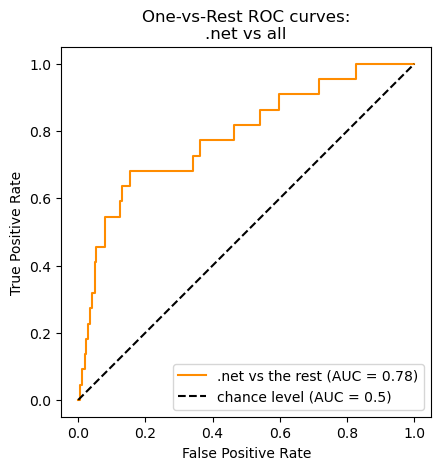

1


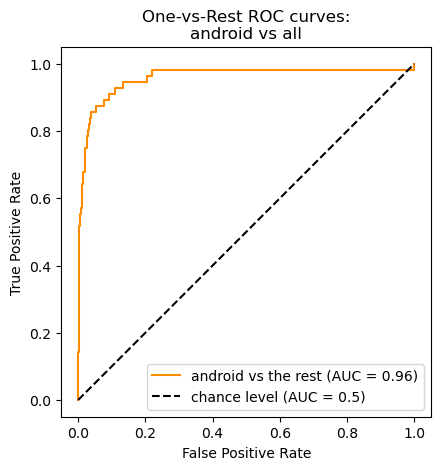

2


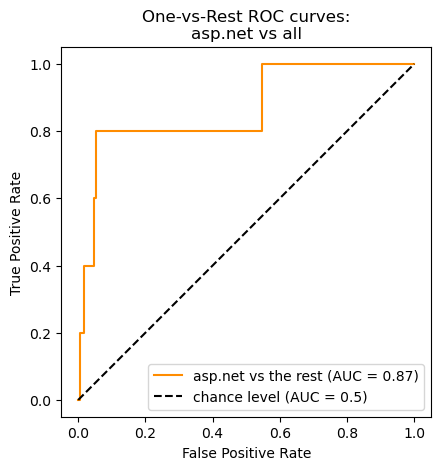

3


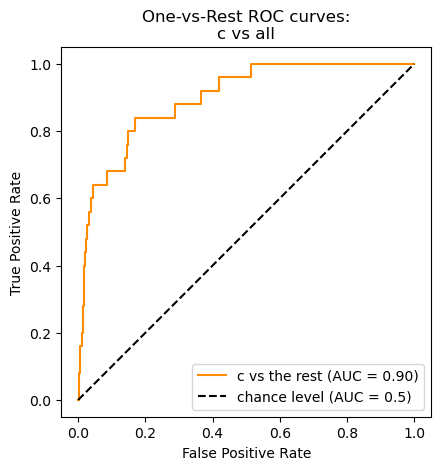

4


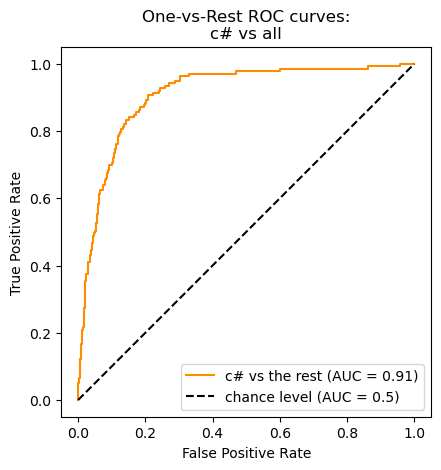

5


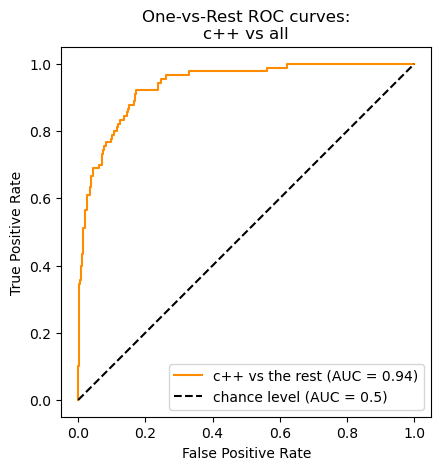

6


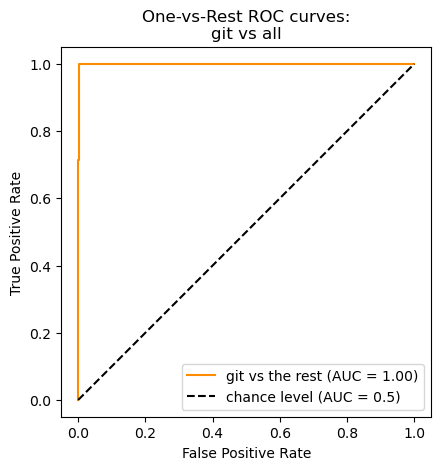

7


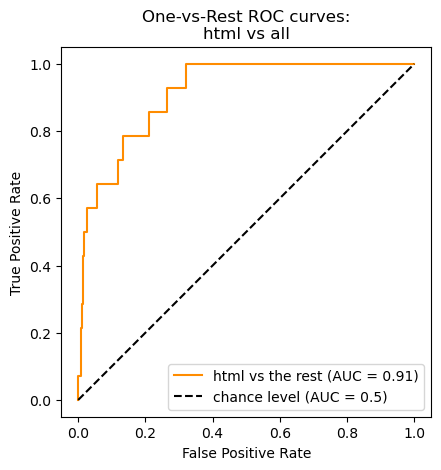

8


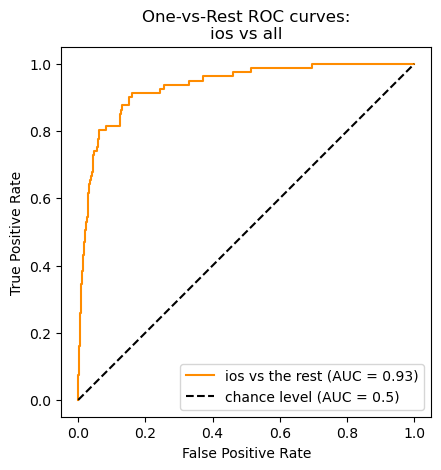

9


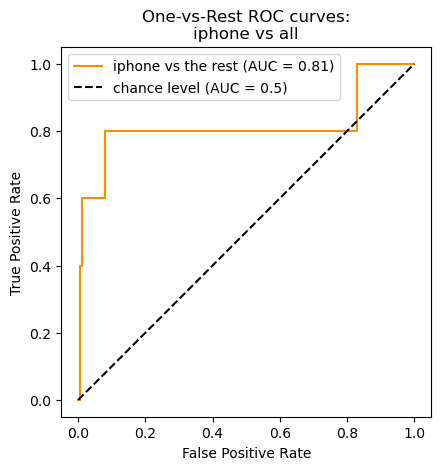

10


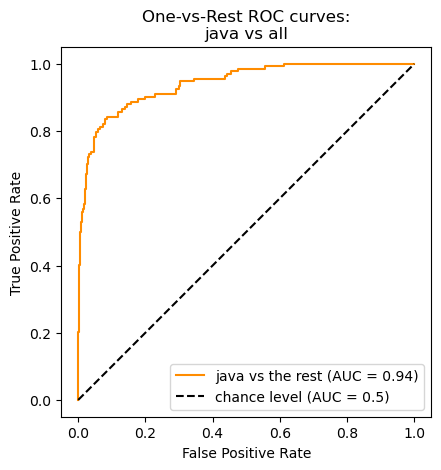

11


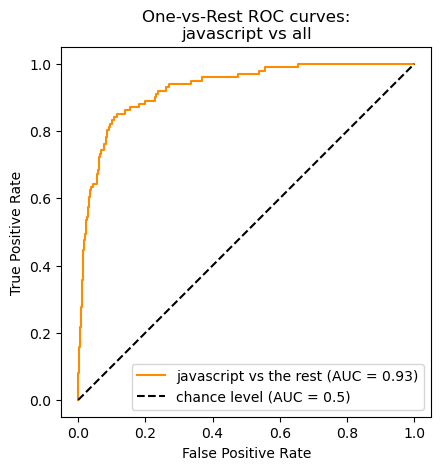

12


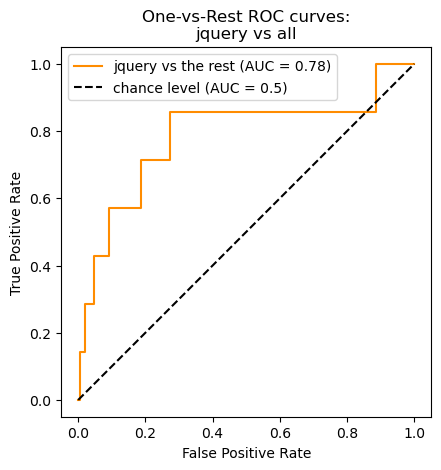

13


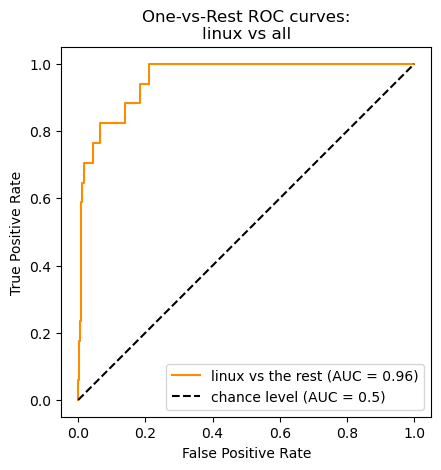

14


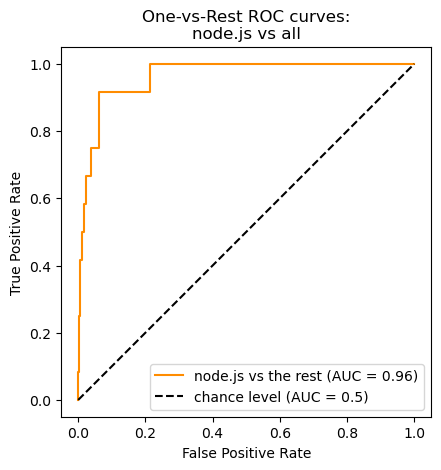

15


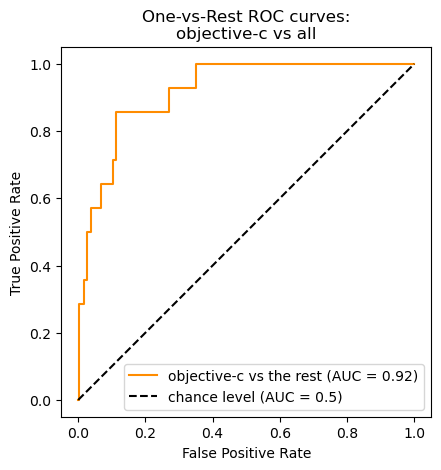

16


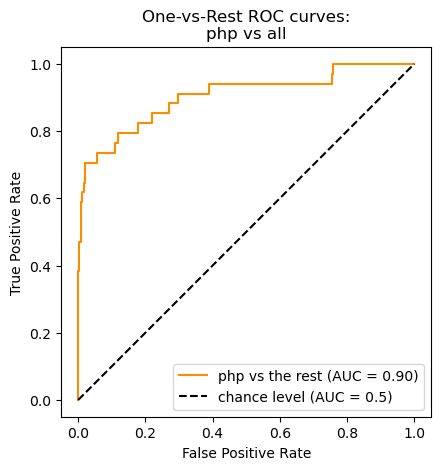

17


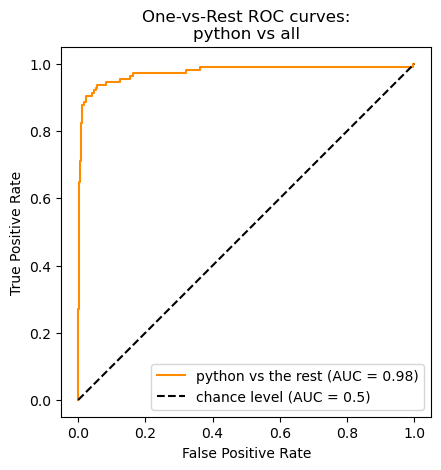

18


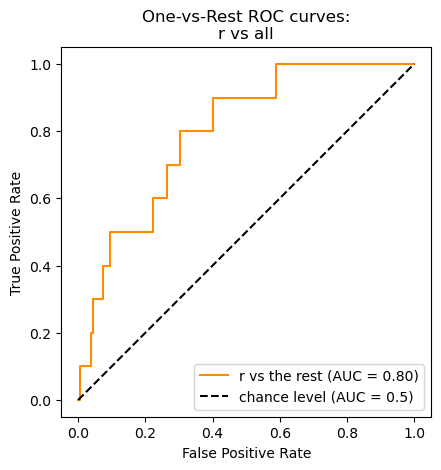

19


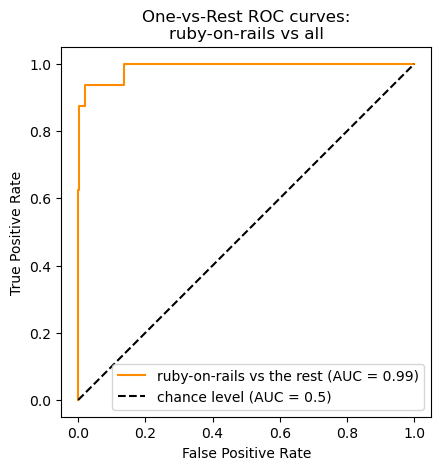

20


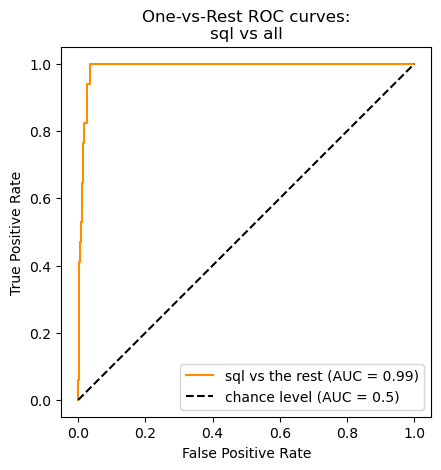

21


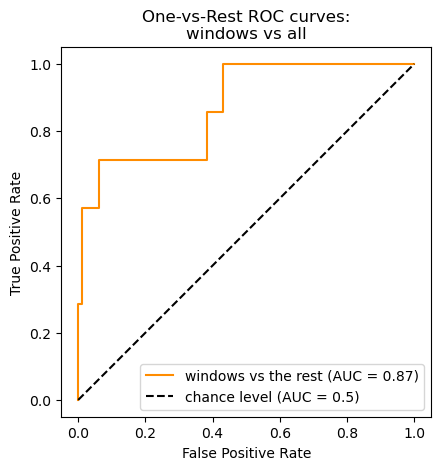

In [126]:
for class_of_interest in label_binarizer.classes_:
    # Choose a specific class for showing the ROC curve
#    class_of_interest = "c#"
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
    print(class_id)
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{class_of_interest} vs the rest",
        color="darkorange",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"One-vs-Rest ROC curves:\n{class_of_interest} vs all")
    plt.legend()
    plt.show()



### Optimal Threshold for Precision-Recall Curve

In [116]:
# TEST CELL
#tag_prediction
y_onehot_test[:, tag_prediction]

(927,)

In [132]:
best_thresholds = []
# pr curve for logistic regression model
#for tag_prediction in range(0, y_score.shape[1]):
for class_of_interest in label_binarizer.classes_:
    # Choose a specific class for showing the ROC curve
#    class_of_interest = "c#"
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
    print(class_id)
    # keep probabilities for the positive outcome only (minority class)
    yhat = y_score[:, class_id]
    # calculate pr-curve
    precision, recall, thresholds = precision_recall_curve(y_onehot_test[:, class_id], yhat)
    ...
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.nanargmax(fscore)
    #if not math.isnan(fscore[ix]):
    best_thresholds.append(thresholds[ix])
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
print('Overall best threshold=%f'% np.mean(best_thresholds))

0
Best Threshold=0.076725, F-Score=0.247
1
Best Threshold=0.247369, F-Score=0.730
2
Best Threshold=0.216942, F-Score=0.200
3
Best Threshold=0.150178, F-Score=0.419
4
Best Threshold=0.231757, F-Score=0.640
5
Best Threshold=0.394066, F-Score=0.659
6
Best Threshold=0.786357, F-Score=0.833
7
Best Threshold=0.120139, F-Score=0.368
8
Best Threshold=0.325801, F-Score=0.667
9
Best Threshold=0.031518, F-Score=0.333
10
Best Threshold=0.442259, F-Score=0.764
11
Best Threshold=0.476801, F-Score=0.653
12
Best Threshold=0.103787, F-Score=0.167
13
Best Threshold=0.109663, F-Score=0.579
14
Best Threshold=0.435676, F-Score=0.455
15
Best Threshold=0.632869, F-Score=0.421
16
Best Threshold=0.324800, F-Score=0.645
17
Best Threshold=0.365813, F-Score=0.897
18
Best Threshold=0.120655, F-Score=0.118
19
Best Threshold=0.483601, F-Score=0.848
20
Best Threshold=0.089674, F-Score=0.596
21
Best Threshold=0.621374, F-Score=0.444
Overall best threshold=0.308537


/var/folders/xx/m7dpq0_56k9crnft1k608cb80000gn/T/ipykernel_32131/2106775706.py:15: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)
/var/folders/xx/m7dpq0_56k9crnft1k608cb80000gn/T/ipykernel_32131/2106775706.py:15: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)
/var/folders/xx/m7dpq0_56k9crnft1k608cb80000gn/T/ipykernel_32131/2106775706.py:15: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)
/var/folders/xx/m7dpq0_56k9crnft1k608cb80000gn/T/ipykernel_32131/2106775706.py:15: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)
/var/folders/xx/m7dpq0_56k9crnft1k608cb80000gn/T/ipykernel_32131/2106775706.py:15: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)
/var/folders/xx/m7dpq0_56k9crn

    Comment:
We use 'np.nanargmax' to retrieve best thresholds because according to : 
https://stackoverflow.com/questions/59728564/max-and-min-returns-np-nan-when-the-np-array-starts-with-np-nan

    "NaN values are propagated, that is if at least one item is NaN, the corresponding max value will be NaN as well. To ignore NaN values (MATLAB behavior), please use nanmax."

### Check scores using stratify

In [85]:
# function to test and get best data split # 
def best_classifier(clf,k,x,y):

    skf = StratifiedKFold(n_splits=k,shuffle=True)

    bestclf = None
    bestf1 = 0
    bestsplit = []
    lst_accu_stratified = []
    cnt = 1
    totalf1 = 0

    for train_index,test_index in skf.split(x,y):
        x_train,x_test = x.iloc[train_index],x.iloc[test_index]
        y_train,y_test = y.iloc[train_index],y.iloc[test_index]
        tf_vect = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)
        X_train_dtm = tf_vect.fit_transform(x_train)
        vocab = tf_vect.get_feature_names_out()
        X_test_dtm = tf_vect.transform(x_test)
        clf.fit(densify(X_train_dtm, vocab),y_train)
        predicted_y = clf.predict(densify(tfidf_vector=X_test_dtm, features=vocab))
        f1 = metrics.f1_score(y_test, predicted_y, average='macro')
        totalf1 = totalf1+f1
        lst_accu_stratified.append(clf.score(X_test_dtm, y_test))
        print(y_test.shape)
        # Print the output.
        print('List of possible accuracy:', lst_accu_stratified)
        print('\nMaximum Accuracy That can be obtained from this model is:',
          max(lst_accu_stratified)*100, '%')
        print('\nMinimum Accuracy:',
          min(lst_accu_stratified)*100, '%')
        print(cnt," iteration f1 score",f1)
        if cnt==10:
            avg = totalf1/10
            print(avg)
        if f1>bestf1:
            bestf1 = f1
            bestclf = base.clone(clf, safe=True) #copy.deepcopy(clf)
            bestsplit = [train_index,test_index]

        cnt = cnt+1   
    return [bestclf,bestf1,bestsplit] 
best_classifier(cross_validated_lr, 5, X, y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2472 entries, 0 to 2471
Columns: 36252 entries, 00 to 읿r
dtypes: float64(36252)
memory usage: 683.7 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618 entries, 0 to 617
Columns: 36252 entries, 00 to 읿r
dtypes: float64(36252)
memory usage: 170.9 MB
None


/Users/souha_kassab/opt/miniconda3/envs/oc_p5/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


(618,)
List of possible accuracy: [0.6634304207119741]

Maximum Accuracy That can be obtained from this model is: 66.34304207119742 %

Minimum Accuracy: 66.34304207119742 %
1  iteration f1 score 0.44622252129767137
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2472 entries, 0 to 2471
Columns: 38127 entries, 00 to 읿r
dtypes: float64(38127)
memory usage: 719.1 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618 entries, 0 to 617
Columns: 38127 entries, 00 to 읿r
dtypes: float64(38127)
memory usage: 179.8 MB
None


/Users/souha_kassab/opt/miniconda3/envs/oc_p5/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


(618,)
List of possible accuracy: [0.6634304207119741, 0.6472491909385113]

Maximum Accuracy That can be obtained from this model is: 66.34304207119742 %

Minimum Accuracy: 64.72491909385113 %
2  iteration f1 score 0.4712970985433683
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2472 entries, 0 to 2471
Columns: 38802 entries, 00 to 읿r
dtypes: float64(38802)
memory usage: 731.8 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618 entries, 0 to 617
Columns: 38802 entries, 00 to 읿r
dtypes: float64(38802)
memory usage: 183.0 MB
None


/Users/souha_kassab/opt/miniconda3/envs/oc_p5/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


(618,)
List of possible accuracy: [0.6634304207119741, 0.6472491909385113, 0.6343042071197411]

Maximum Accuracy That can be obtained from this model is: 66.34304207119742 %

Minimum Accuracy: 63.43042071197411 %
3  iteration f1 score 0.42563220064928886
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2472 entries, 0 to 2471
Columns: 38855 entries, 00 to 읿r
dtypes: float64(38855)
memory usage: 732.8 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618 entries, 0 to 617
Columns: 38855 entries, 00 to 읿r
dtypes: float64(38855)
memory usage: 183.2 MB
None


/Users/souha_kassab/opt/miniconda3/envs/oc_p5/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


(618,)
List of possible accuracy: [0.6634304207119741, 0.6472491909385113, 0.6343042071197411, 0.6537216828478964]

Maximum Accuracy That can be obtained from this model is: 66.34304207119742 %

Minimum Accuracy: 63.43042071197411 %
4  iteration f1 score 0.44759462976567566
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2472 entries, 0 to 2471
Columns: 39144 entries, 00 to 视频
dtypes: float64(39144)
memory usage: 738.3 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618 entries, 0 to 617
Columns: 39144 entries, 00 to 视频
dtypes: float64(39144)
memory usage: 184.6 MB
None
(618,)
List of possible accuracy: [0.6634304207119741, 0.6472491909385113, 0.6343042071197411, 0.6537216828478964, 0.6537216828478964]

Maximum Accuracy That can be obtained from this model is: 66.34304207119742 %

Minimum Accuracy: 63.43042071197411 %
5  iteration f1 score 0.46593910762562596


/Users/souha_kassab/opt/miniconda3/envs/oc_p5/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


[LogisticRegression(C=10.0, penalty='l1', solver='liblinear'),
 0.4712970985433683,
 [array([   2,    3,    4, ..., 3086, 3087, 3089]),
  array([   0,    1,    5,    6,   14,   19,   27,   31,   35,   36,   38,
           39,   42,   50,   57,   61,   64,   66,   75,   79,   92,  114,
          119,  127,  130,  134,  136,  137,  140,  151,  154,  156,  158,
          163,  164,  166,  176,  181,  182,  192,  200,  202,  210,  219,
          225,  231,  234,  241,  242,  245,  253,  257,  261,  276,  278,
          286,  288,  293,  299,  301,  306,  307,  333,  335,  339,  344,
          361,  370,  372,  373,  390,  393,  394,  395,  400,  403,  405,
          406,  408,  418,  421,  424,  429,  437,  440,  446,  450,  454,
          459,  467,  470,  476,  479,  482,  487,  490,  503,  507,  509,
          516,  518,  525,  532,  533,  542,  545,  551,  555,  563,  565,
          578,  580,  582,  589,  600,  607,  610,  613,  623,  626,  628,
          630,  632,  640,  643,  644, 

-- Comment ---
Model seem to be underfit, maybe because of reduced datasize

In [86]:
len(y_onehot_test[:, tag_prediction][y_onehot_test[:, tag_prediction]==1])

7

If we are interested in a threshold that results in the best balance of precision and recall, then this is the same as optimizing the F(1)-measure that summarizes the harmonic mean of both measures.

    F-Measure = (2 * Precision * Recall) / (Precision + Recall)

As in the previous section, the naive approach to finding the optimal threshold would be to calculate the F-measure for each threshold. We can achieve the same effect by converting the precision and recall measures to F-measure directly; for example:

/var/folders/xx/m7dpq0_56k9crnft1k608cb80000gn/T/ipykernel_32131/837762414.py:8: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)


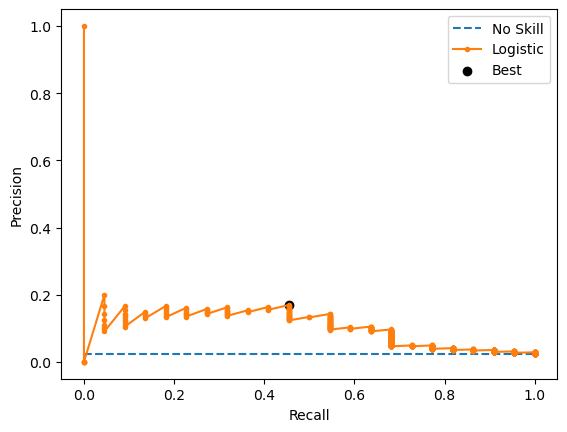

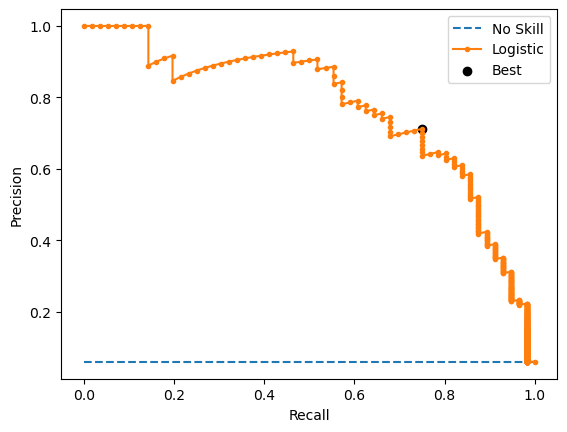

/var/folders/xx/m7dpq0_56k9crnft1k608cb80000gn/T/ipykernel_32131/837762414.py:8: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)


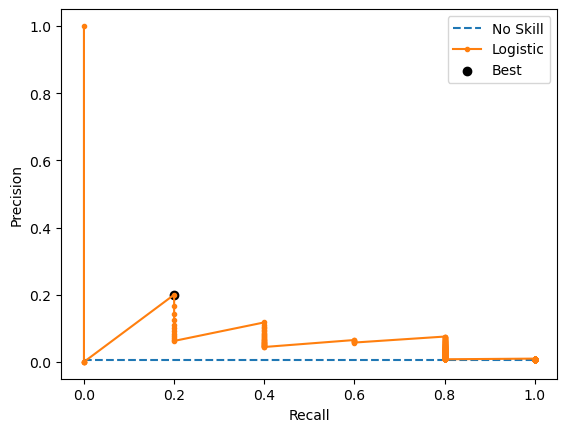

/var/folders/xx/m7dpq0_56k9crnft1k608cb80000gn/T/ipykernel_32131/837762414.py:8: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)


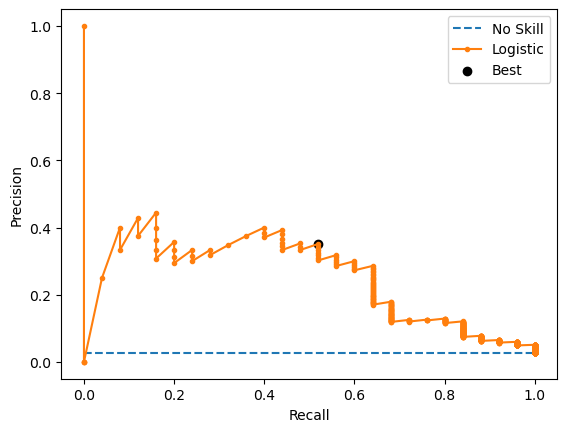

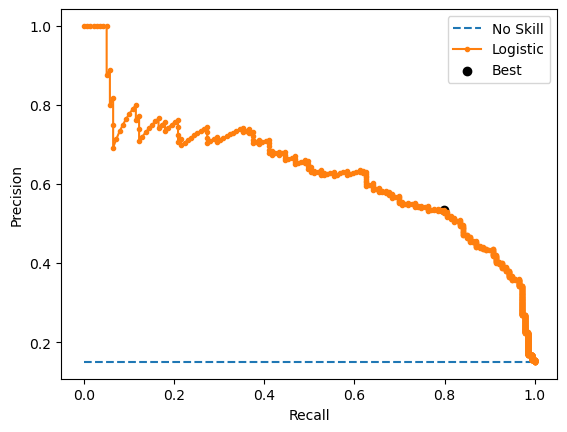

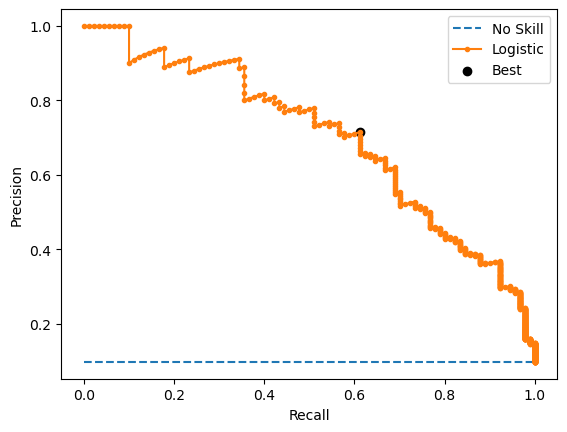

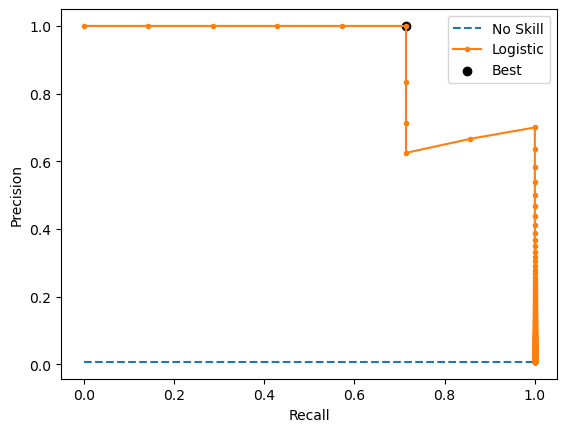

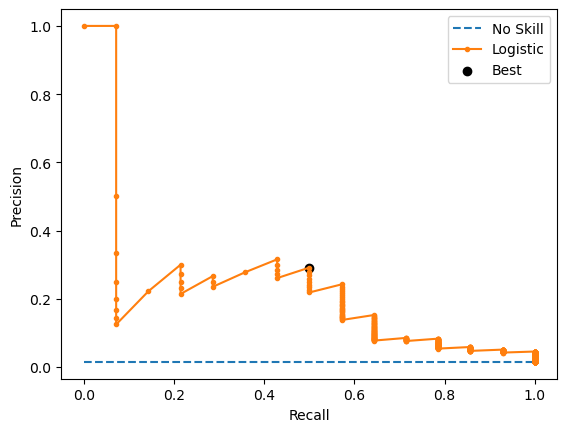

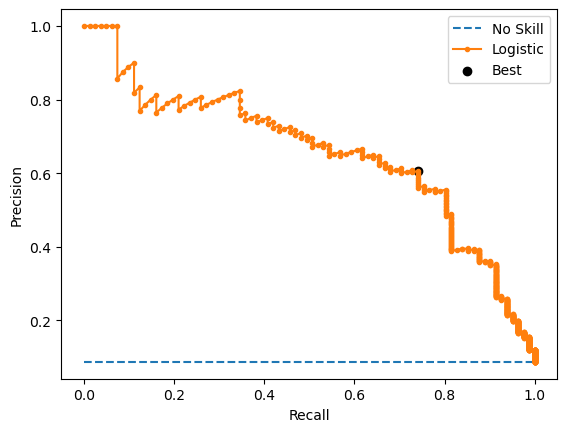

/var/folders/xx/m7dpq0_56k9crnft1k608cb80000gn/T/ipykernel_32131/837762414.py:8: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)


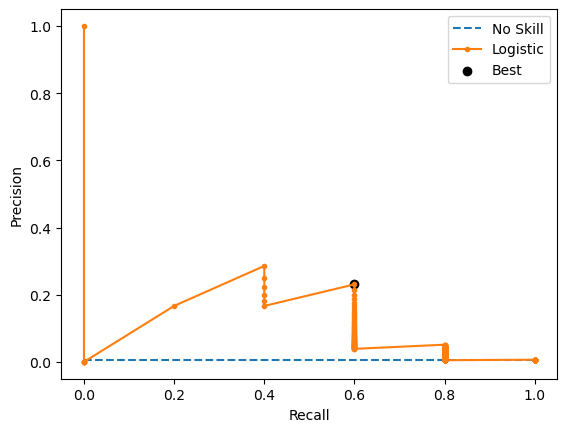

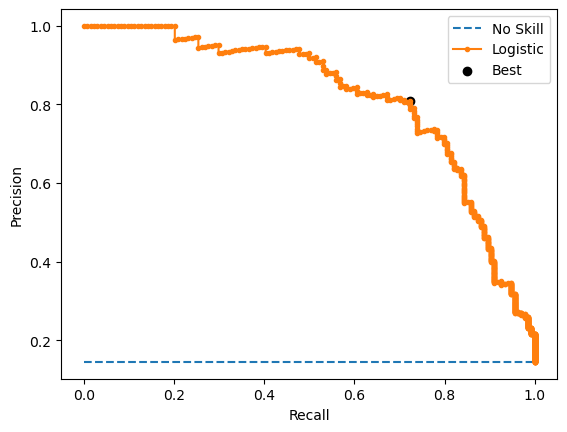

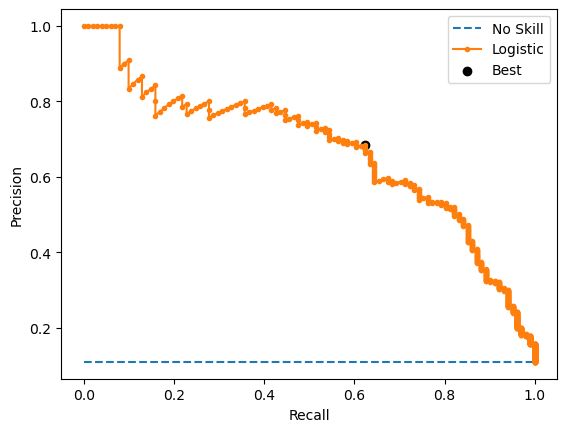

/var/folders/xx/m7dpq0_56k9crnft1k608cb80000gn/T/ipykernel_32131/837762414.py:8: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)


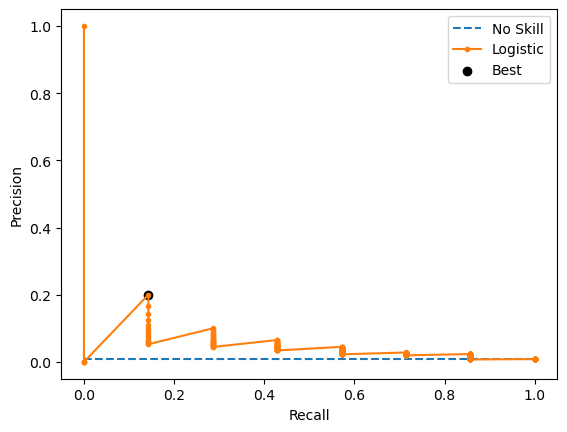

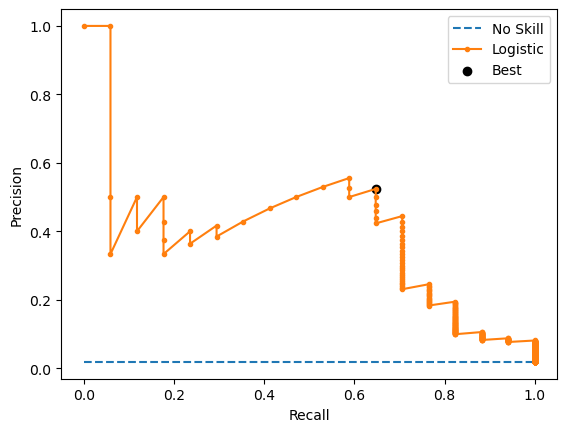

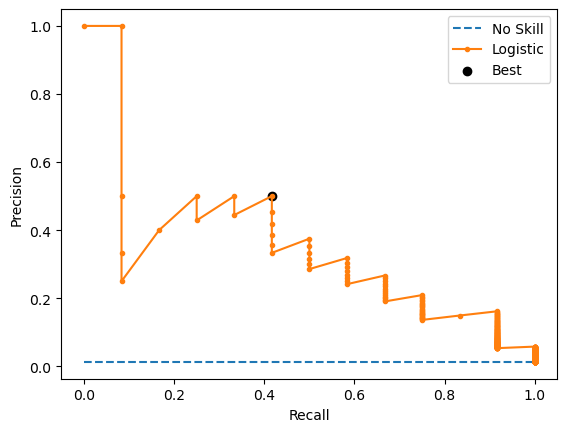

/var/folders/xx/m7dpq0_56k9crnft1k608cb80000gn/T/ipykernel_32131/837762414.py:8: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)


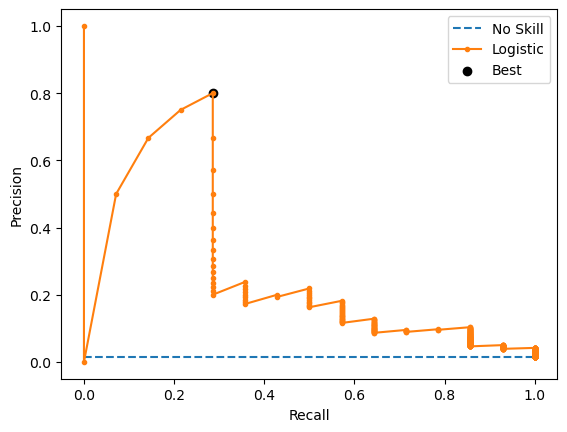

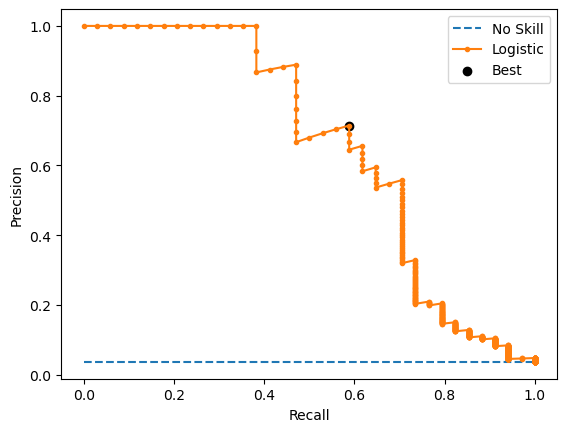

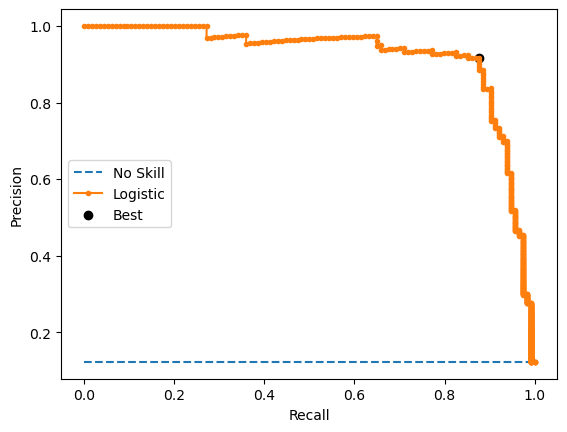

/var/folders/xx/m7dpq0_56k9crnft1k608cb80000gn/T/ipykernel_32131/837762414.py:8: RuntimeWarning: invalid value encountered in divide
  fscore = (2 * precision * recall) / (precision + recall)


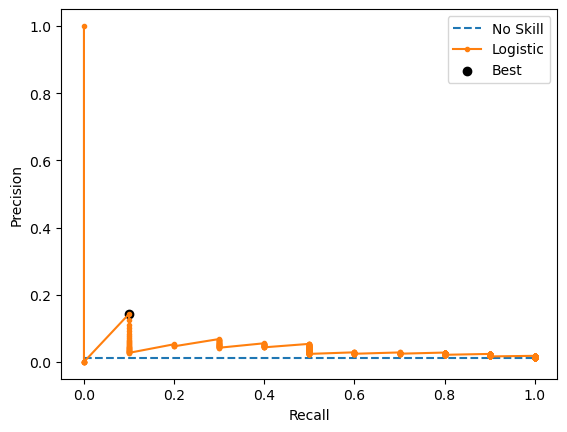

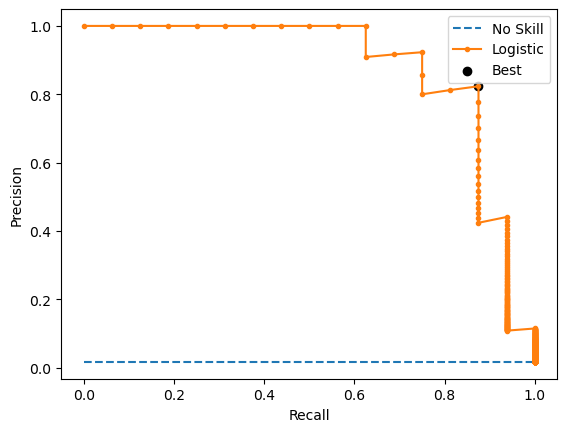

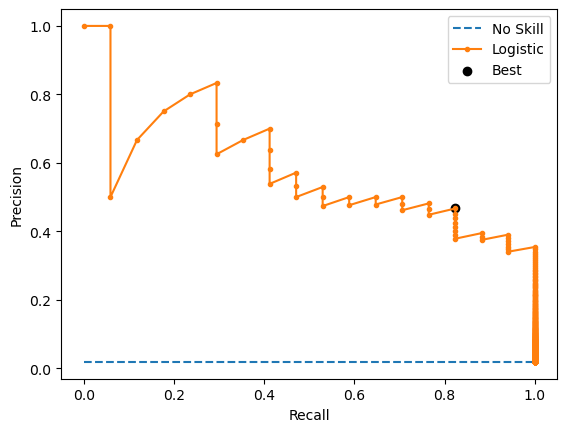

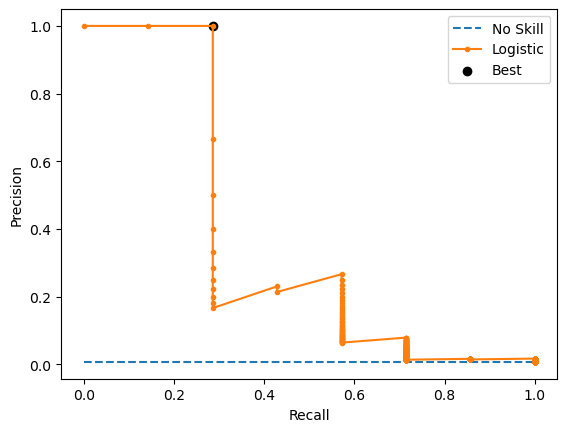

In [133]:
for tag_prediction in range(0, y_score.shape[1]):

    # keep probabilities for the positive outcome only (minority class)
    yhat = y_score[:, tag_prediction]
    # calculate pr-curve
    precision, recall, thresholds = precision_recall_curve(y_onehot_test[:, tag_prediction], yhat)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.nanargmax(fscore)
    # --------------------------- #
    # plot the roc curve for the model
    no_skill = len(y_onehot_test[:, tag_prediction][y_onehot_test[:, tag_prediction]==1]) / len(y_onehot_test[:])
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label='Logistic')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    # show the plot
    plt.show()
    
    

# Predict mono-tag

Remonter aux tags pour voir le nombre de tags associes dont la proba est superieure au threshold
Construire des vecteurs de 5, 10 ou 100 tags differents
Refaire en utilisant le meme dataset que pour le unsupervised...

In [194]:
[index for colname in df_yscore.columns
 for index in df_yscore.loc[(df_yscore[colname]>best_thresh),colname].index]

[90,
 161,
 167,
 187,
 202,
 353,
 376,
 449,
 619,
 624,
 757,
 809,
 905,
 35,
 48,
 84,
 87,
 88,
 99,
 111,
 117,
 120,
 145,
 152,
 173,
 196,
 207,
 208,
 230,
 243,
 257,
 276,
 312,
 379,
 400,
 401,
 409,
 413,
 416,
 436,
 451,
 466,
 553,
 555,
 566,
 584,
 599,
 630,
 642,
 675,
 716,
 717,
 723,
 749,
 755,
 764,
 774,
 817,
 828,
 856,
 858,
 888,
 916,
 48,
 733,
 32,
 92,
 97,
 106,
 147,
 181,
 200,
 211,
 282,
 333,
 360,
 395,
 421,
 467,
 574,
 672,
 692,
 719,
 734,
 760,
 850,
 889,
 892,
 911,
 9,
 10,
 20,
 27,
 38,
 40,
 44,
 49,
 50,
 58,
 68,
 69,
 76,
 79,
 81,
 82,
 83,
 89,
 92,
 93,
 96,
 104,
 105,
 113,
 114,
 125,
 133,
 137,
 138,
 143,
 146,
 159,
 161,
 168,
 170,
 175,
 176,
 184,
 189,
 190,
 194,
 198,
 226,
 233,
 234,
 237,
 241,
 246,
 247,
 249,
 253,
 259,
 262,
 266,
 267,
 270,
 272,
 286,
 291,
 295,
 296,
 298,
 309,
 315,
 318,
 319,
 324,
 341,
 346,
 351,
 356,
 358,
 363,
 368,
 369,
 375,
 389,
 394,
 397,
 404,
 407,
 410,
 412,
 

In [200]:
for colname in df_yscore.columns:
    print(colname, df_yscore.loc[(df_yscore[colname]>best_thresh),colname].index) 

.net Index([90, 161, 167, 187, 202, 353, 376, 449, 619, 624, 757, 809, 905], dtype='int64')
android Index([ 35,  48,  84,  87,  88,  99, 111, 117, 120, 145, 152, 173, 196, 207,
       208, 230, 243, 257, 276, 312, 379, 400, 401, 409, 413, 416, 436, 451,
       466, 553, 555, 566, 584, 599, 630, 642, 675, 716, 717, 723, 749, 755,
       764, 774, 817, 828, 856, 858, 888, 916],
      dtype='int64')
asp.net Index([48, 733], dtype='int64')
c Index([ 32,  92,  97, 106, 147, 181, 200, 211, 282, 333, 360, 395, 421, 467,
       574, 672, 692, 719, 734, 760, 850, 889, 892, 911],
      dtype='int64')
c# Index([  9,  10,  20,  27,  38,  40,  44,  49,  50,  58,
       ...
       897, 899, 900, 901, 902, 904, 905, 910, 916, 925],
      dtype='int64', length=187)
c++ Index([ 12,  19,  21,  46,  50,  55,  61,  78,  91, 107, 114, 116, 125, 135,
       142, 147, 148, 154, 158, 165, 169, 186, 191, 201, 225, 245, 248, 250,
       252, 256, 262, 265, 277, 278, 310, 342, 343, 352, 365, 381, 420, 421,
     

In [323]:
# PREDICT PROBABILITIES WITH BEST THRESHOLDS
#df_yscore[(df_yscore>best_thresh)]
# PREDICT TAGS WITH MAX PROBAS
df_yscore[df_yscore.loc[4, :]==df_yscore==max(df_yscore.loc[4, :])]

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
stop

In [233]:
s = pd.Series((df_yscore.loc[3])>best_thresh, name='bools')
df_yscore.loc[3, s.values]

javascript    0.740758
Name: 3, dtype: float64

In [28]:
def retrieve_proba(y_proba):
    df_yproba=pd.DataFrame(y_proba, columns=label_binarizer.classes_)
# -- Get tags from tag_proba>best_threshold ------- ######
    s = pd.Series(((df_yproba.values)>best_thresh)[0])
    return list(df_yproba.loc[:, s.values])[0]
# ----------------------------------------------------------------- ####
# -- Get tags with highest probabilities from predict_proba() ----- ####
def predict_highestX_proba(tags_proba_df): #parameter can also be predict_highestX_proba(tags_predicted_probas):
    #df_yproba=pd.DataFrame(tags_predicted_probas, columns=label_binarizer.classes_)
    
    b=list(tags_proba_df.values[0])
    a=list(tags_proba_df.columns)
    return sorted(zip(b, a), reverse=True)[:5]

In [312]:
#densify(tfidf_vector=tf_fit.transform(X_test), features=vocab)
test_x = densify(tf_fit.transform(['Can I use react to develop an app on ios?']), features=vocab)
y_trial = cross_validated_lr.predict_proba(test_x)
(retrieve_proba(y_trial))

#s

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Columns: 35581 entries, 00 to 视频
dtypes: float64(35581)
memory usage: 278.1 KB
None


['javascript']

In [ ]:
print(predict_highestX_proba(df_ytrial))

In [299]:
s = pd.Series(((df_yproba.values)>best_thresh)[0])
(df_yproba.loc[:, s.values])

,python
0,0.941016


In [17]:
#densify(tfidf_vector=tf_fit.transform(X_test), features=vocab)
test_x = densify(tf_fit.transform(['Can I use react to develop an app on ios?']), features=vocab)
y_trial = lr_classifier.predict_proba(test_x)
#(retrieve_proba(y_trial))

#s

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Columns: 35581 entries, 00 to 视频
dtypes: float64(35581)
memory usage: 278.1 KB
None


In [19]:
best_thresh=0.308537
df_yproba=pd.DataFrame(y_proba, columns=label_binarizer.classes_)
# Get tags from tag_proba>best_threshold
s = pd.Series(((df_yproba.values)>best_thresh)[0])

In [26]:
df_ytrial = pd.DataFrame(y_trial)
np.max(df_ytrial)

0.6719799250252672

# SAVE PICKLES

In [324]:
pickle.dump(cross_validated_lr, open("Cross_valid_lr.p", "wb"))

pickle.dump(tf_fit, open("vectorizer_tfidf_31052023.p", "wb"))

In [12]:
# LOAD MODEL AND WORD VECTORIZER SAVED IN PICKLE
lr_classifier = pickle.load(open("Cross_valid_lr.p", "rb"))
tf_fit = vectorizer = pickle.load(open("vectorizer_tfidf_31052023.p", "rb"))


In [124]:
pickle.dump(Multi_text_clf, open("Multilabel_classifier.p", "wb"))
pickle.dump(mlb, open("Multilabel_binarizer_Yfit.p", "wb"))

pickle.dump(classifiers, open("classifiers_list.p", "wb"))

In [123]:
# TEST CELL


classifiers






[Pipeline(steps=[('vect',
                  TfidfVectorizer(max_df=0.95,
                                  stop_words=['after', 'below', 'weren', 'out',
                                              'shan', 'these', 'by', 'but',
                                              'whom', 'run', 'who', 'on', 't',
                                              'doesn', 'our', 'my', 'what',
                                              'aren', 'before', 'it', 'a', 'you',
                                              'herself', 'has', "didn't", 'were',
                                              'itself', 'from', 'only', 'should', ...])),
                 ('lr',
                  OneVsRestClassifier(estimator=LogisticRegression(C=10.0,
                                                                   penalty='l1',
                                                                   solver='liblinear')))]),
 Pipeline(steps=[('vect',
                  TfidfVectorizer(max_df=0.95,
                 

# Pipelines for multilabel predictions
## Re-Split data for multilabel predictions

In [51]:
multilbl_X = (shuffled_data.loc[:, 'concatenated_query_bow_lem']).values
print(X.shape)
multilbl_y = ((shuffled_data.loc[:, 'Tags_words']).values).flatten()
print(y.shape)
values = (shuffled_data.loc[:, 'Tags_words']).value_counts()/(shuffled_data.loc[:, 'Tags_words']).shape[0]
#print(values)
multilbl_y

(3090,)
(3090,)


array([list(['javascript', 'jquery', 'html', 'forms', 'contenteditable']),
       list(['javascript', 'performance', 'module', 'webpack', 'babeljs']),
       list(['python', 'windows', 'process', 'subprocess', 'fork']), ...,
       list(['c++', 'qt', 'qtcore', 'qdir', 'qfileinfo']),
       list(['c#', 'ef-code-first', 'foreign-keys', 'data-annotations', 'entity-framework-6']),
       list(['java', 'python', 'multithreading', 'multiprocessing', 'gil'])],
      dtype=object)

In [54]:
X_train, X_test, y_train,  y_test = train_test_split(multilbl_X, multilbl_y, test_size=0.3,random_state=42) 
                                                     #stratify=multilbl_y['uniq'])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2163,) (927,) (2163,) (927,)


## Construct target made from multiple tags per query
    BUILD A TARGET WITH 100 TAGS RANGING FROM MOST COMMONLY FOUND IN DATASET (first 22 tags) TO RAREST TAGS

In [47]:
flat_list = list(shuffled_data['unique_rare_tag'])

rarest_tags = [item[0] for item in Counter(flat_list).most_common(80)]
#(list(small_df['unique_commn_tag'].unique()) + rarest_tags)

TAGSlist_to_predict = list(shuffled_data['unique_commn_tag'].unique()) + rarest_tags
TAGSlist_to_predict

['javascript',
 'python',
 'c++',
 'java',
 'ios',
 'ruby-on-rails',
 'c#',
 'php',
 'linux',
 'android',
 'c',
 'html',
 'windows',
 'asp.net',
 'jquery',
 '.net',
 'objective-c',
 'iphone',
 'r',
 'git',
 'sql',
 'node.js',
 'memory-leaks',
 'ipad',
 'subprocess',
 'plugins',
 'ajax',
 'visual-studio-2012',
 'datagridview',
 'apple-push-notifications',
 'tomcat',
 'jackson',
 'controller',
 'semaphore',
 'structure',
 'deserialization',
 'date',
 'twitter-bootstrap',
 'webview',
 'hive',
 'timing',
 'asp.net-web-api',
 'asp.net-web-api2',
 'allocator',
 'solaris',
 'command-line-interface',
 'ipython',
 'owin',
 'micro-optimization',
 'protocol-buffers',
 'resize',
 'clipboard',
 'c#-3.0',
 'wcf',
 'javafx',
 'webclient',
 'amazon-sqs',
 'cpu-usage',
 'task',
 'razor',
 'ruby-on-rails-3.2',
 'orm',
 'jersey-2.0',
 'laravel-5',
 'short',
 'java-metro-framework',
 'properties',
 'boost-asio',
 'prepared-statement',
 'sql-server-2005',
 'time',
 'autolayout',
 'visual-studio-2008',
 'de

## Build MultilabelBinarizer for OneVsRestClassifier

    We will wrap the LogisticRegressionClassifier in a One-Vs-Rest Classifier. For that we need to build a multilabellbinarizer for our target (TAGSlist_to_predict)

In [88]:
mlb = MultiLabelBinarizer()
mlb

MultiLabelBinarizer()

In [ ]:
def binarize_mutli_target():
    mlb.fit(y_train)
    print(mlb.classes_)
    (len(mlb.classes_))
    print(mlb_y.shape)
    df = pd.DataFrame(mlb_y, columns=mlb.classes_)
    df
    new_y=df[TAGSlist_to_predict[:numb_tags]].values
    new_y.shape

In [58]:
mlb.fit(y)
print(mlb.classes_)
(len(mlb.classes_))


['.class-file' '.htaccess' '.lib' ... 'zip' 'zsh' 'zxing']


4146

In [59]:
# convert y into a matrix of samplesXnumber_of_features with 2 classes : 0 or 1 ==> number of columns of mlb_y will be the same as 
# the total number of different tags present in all the list of y
mlb_y = mlb.transform(y)
print(mlb_y.shape)
df = pd.DataFrame(mlb_y, columns=mlb.classes_)
df
# Still need to stratify in order to shuffle data

(3090, 4146)


,.class-file,.htaccess,.lib,.net,.net-2.0,.net-3.5,.net-4.0,.net-4.5,.net-4.7.1,.net-6.0,...,youtube,youtube-data-api,yuv,zend-db-table,zend-framework,zero-initialization,zeromq,zip,zsh,zxing
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3085,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3086,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3087,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3088,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Build model with different number of tags

In [64]:
classif_lr = OneVsRestClassifier(LogisticRegression(C= 10.0, penalty="l1", solver="liblinear"))

Multi_text_clf = Pipeline([
     ('vect', TfidfVectorizer(stop_words=stop_w, max_df=0.95, min_df=1)),
    ('lr', classif_lr)]
)
Multi_text_clf

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.95,
                                 stop_words=['after', 'below', 'weren', 'out',
                                             'shan', 'these', 'by', 'but',
                                             'whom', 'run', 'who', 'on', 't',
                                             'doesn', 'our', 'my', 'what',
                                             'aren', 'before', 'it', 'a', 'you',
                                             'herself', 'has', "didn't", 'were',
                                             'itself', 'from', 'only', 'should', ...])),
                ('lr',
                 OneVsRestClassifier(estimator=LogisticRegression(C=10.0,
                                                                  penalty='l1',
                                                                  solver='liblinear')))])

In [69]:
Multi_text_clf.get_feature_names_out

<bound method Pipeline.get_feature_names_out of Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=0.95,
                                 stop_words=['after', 'below', 'weren', 'out',
                                             'shan', 'these', 'by', 'but',
                                             'whom', 'run', 'who', 'on', 't',
                                             'doesn', 'our', 'my', 'what',
                                             'aren', 'before', 'it', 'a', 'you',
                                             'herself', 'has', "didn't", 'were',
                                             'itself', 'from', 'only', 'should', ...])),
                ('lr',
                 OneVsRestClassifier(estimator=LogisticRegression(C=10.0,
                                                                  penalty='l1',
                                                                  solver='liblinear')))])>

In [93]:
# FIT AND EVALUATE MODEL FOR DIFFERENT NUMBER OF TAGS PER PREDICTION
classifiers = []
acc = []
f1 = []
numb_tags = 0
for numb_tags in np.array([2, 3]):

    # Create a list of corresponding size
    new_y=df[TAGSlist_to_predict[:numb_tags]].values
    new_y.shape
    #new_y=mlb_y[:, :numb_tags]
    # DATA SPLIT INTO TEST AND TRAIN
    X_train, X_test, y_train,  y_test = train_test_split(X, new_y, test_size=0.3, stratify=new_y)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    
    tags_classif = Multi_text_clf.fit(X_train, y_train)
    #print(warnings.catch_warnings)
    classifiers.append(tags_classif)
    # PREDICT
    tags_predictions = tags_classif.predict((X_test))
    acc.append(accuracy_score(y_test, tags_classif.predict((X_test))))
    #RETRIEVE F1-SCORE
    f1.append(f1_score(y_test, tags_classif.predict(X_test), average='weighted'))

print(acc)

(2163,) (927,) (2163, 2) (927, 2)
(2163,) (927,) (2163, 3) (927, 3)
[0.8781014023732471, 0.8122977346278317]


In [98]:
list(df[TAGSlist_to_predict[:numb_tags]].columns)

['javascript', 'python', 'c++']

In [ ]:
 sklearn.metrics.jaccard_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')[source]¶

## f1-score profile

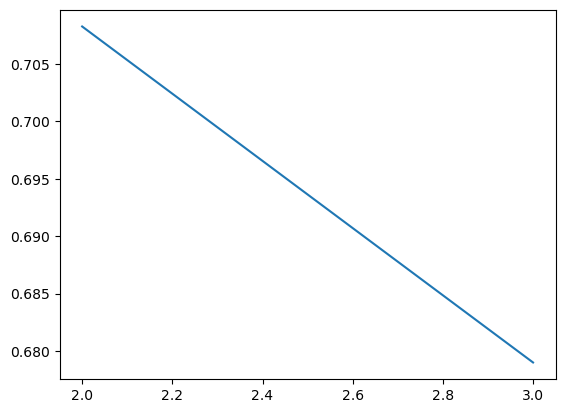

In [102]:
plt.plot(np.array([2, 3]),f1)


## Predict multiple tags

In [121]:
def retrieve_proba(y_proba):
    df_yproba=pd.DataFrame(y_proba, columns=list(df[TAGSlist_to_predict[:numb_tags]].columns))
# -- Get tags from tag_proba>best_threshold ------- ######
    s = pd.Series(((df_yproba.values)>best_thresh)[0])
    return list(df_yproba.loc[:, s.values])[0]
# ----------------------------------------------------------------- ####
# -- Get tags with highest probabilities from predict_proba() ----- ####
def predict_highestX_proba(tags_predicted_probas, labels): #parameter can also be predict_highestX_proba(tags_predicted_probas):
    df_ytrial=pd.DataFrame(tags_predicted_probas, columns=labels)
    
    b=list(df_ytrial.values[0])
    a=list(df_ytrial.columns)
    return sorted(zip(b, a), reverse=True)[:5]

In [122]:
best_thresh=0.308537
test_x = ['Can I use react to develop an app on ios?']
y_trial = Multi_text_clf.predict_proba(test_x)
#df_ytrial = pd.DataFrame(y_trial, columns=list(df[TAGSlist_to_predict[:numb_tags]].columns))
#df_ytrial
predict_highestX_proba(y_trial, list(df[TAGSlist_to_predict[:numb_tags]].columns))

[(0.3337038438934135, 'javascript'),
 (0.010709733970097064, 'python'),
 (0.003751472009225379, 'c++')]

In [ ]:
stop

In [101]:
multilabel_confusion_matrix(y_test, tags_classif.predict((X_test)), labels=list(df[TAGSlist_to_predict[:numb_tags]].columns))

/Users/souha_kassab/opt/miniconda3/envs/oc_p5/lib/python3.9/site-packages/numpy/lib/arraysetops.py:729: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


UFuncTypeError: ufunc 'maximum' did not contain a loop with signature matching types (dtype('<U21'), dtype('<U21')) -> None

In [79]:
## Check scores with stratify 
# function to test and get best data split # 
def best__multiclassifier(clf,k,x,y):

    skf = StratifiedKFold(n_splits=k,shuffle=True)

    bestclf = None
    bestf1 = 0
    bestsplit = []
    lst_accu_stratified = []
    cnt = 1
    totalf1 = 0

    for train_index,test_index in skf.split(x,mlb.transform(y)):
        x_train,x_test = x.iloc[train_index],x.iloc[test_index]
        y_train,y_test = y.iloc[train_index],y.iloc[test_index]
        
        clf.fit((x_train),y_train)
        predicted_stratified_y = clf.predict(x_test)
        f1 = metrics.f1_score(y_test, predicted_stratified_y, average='weighted')
        totalf1 = totalf1+f1
        lst_accu_stratified.append(clf.score(x_test, y_test))
        print(y_test.shape)
        # Print the output.
        print('List of possible accuracy:', lst_accu_stratified)
        print('\nMaximum Accuracy That can be obtained from this model is:',
          max(lst_accu_stratified)*100, '%')
        print('\nMinimum Accuracy:',
          min(lst_accu_stratified)*100, '%')
        print(cnt," iteration f1 score",f1)
        if cnt==10:
            avg = totalf1/10
            print(avg)
        if f1>bestf1:
            bestf1 = f1
            bestclf = base.clone(clf, safe=True) #copy.deepcopy(clf)
            bestsplit = [train_index,test_index]

        cnt = cnt+1   
    return [bestclf,bestf1,bestsplit]     
   


In [80]:
best__multiclassifier(Multi_text_clf, 5, X, y)
#predicted_stratified_y

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'multilabel-indicator' instead.

In [ ]:
stop
def train_eval_model(model, X_train, y_train, X_test, y_test): 
    pipe = (model["classif"])
    start_time = time.time()
    # Fit model
    pipe.fit(X_train, y_train)
    print(pipe.get_params())
    
    # Check model
    train_predictions = pipe.predict(X_train)
    train_time = time.time() - start_time    
    train_acc = accuracy_score(y_train, train_predictions)  
  
    # Evaluate model
    test_predictions = pipe.predict(X_test)
    test_acc = accuracy_score(y_test, test_predictions)
    #test_predicted_proba = pipe.predict_proba(X_test)
    #
   
    #test_MCM = multilabel_confusion_matrix(y_test, test_predictions)
    
   # test_F1 = (y_test, test_predictions)
    #test_report = classification_report(y_test, test_predictions)
     # initialize data of lists.
    metrics = {'Metrics_name': ['F1', 'classification_report', 'accuracy'],
        'Metric_value': [, , ]}
    test_metrics = pd.DataFrame(metrics)
    test_metrics = test_metrics.set_index('Metrics_name')
#RMSLE
    
    model_details = {"name": model["name"], "train_set_metrics":train_metrics, "test_set_metrics":test_metrics,
                     "train_time": train_time, "model": pipe}
    return model_details